# OSMnx features demo

Author: [Geoff Boeing](https://geoffboeing.com/)

Get street networks and other spatial data anywhere in the world from OpenStreetMap then analyze and visualize them.

More info:

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  
This notebook provides a quick tour of some of OSMnx's key features including how to:

  - download/model street networks
  - calculate stats
  - visualize centrality
  - impute speeds/travel times and calculate shortest paths
  - attach and visualize elevation data and edge grades
  - download/model other infrastructure types
  - download points of interest data

In [7]:
import networkx as nx
import osmnx as ox

ox.settings.requests_kwargs = {'verify': False}

%matplotlib inline
ox.__version__

'1.7.0'

## Working with street networks

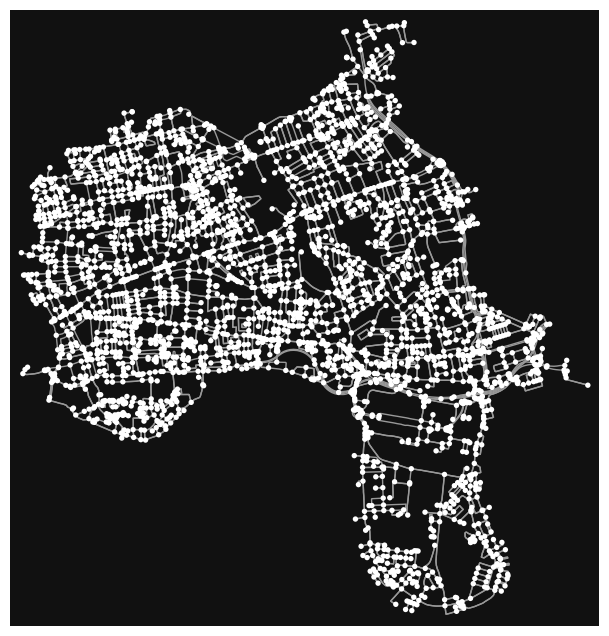

In [8]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place("London Borough of Tower Hamlets, London, UK", network_type="drive")
fig, ax = ox.plot_graph(G)

OSMnx geocodes the query "Piedmont, California, USA" to retrieve the place boundaries of that city from the Nominatim API, retrieves the drivable street network data within those boundaries from the Overpass API, constructs a graph model, then simplifies/corrects its topology such that nodes represent intersections and dead-ends and edges represent the street segments linking them. All of this is discussed in detail in the documentation and these examples.

OSMnx models all networks as NetworkX `MultiDiGraph` objects. You can convert to:
  - undirected MultiGraphs
  - DiGraphs without (possible) parallel edges
  - GeoPandas node/edge GeoDataFrames

In [9]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.utils_graph.get_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.utils_graph.get_digraph(G)

In [10]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
104341,51.514724,-0.030101,3,NaN,POINT (-0.03010 51.51472)
104343,51.515636,-0.028922,3,NaN,POINT (-0.02892 51.51564)
106734,51.509475,-0.060494,4,NaN,POINT (-0.06049 51.50947)
106735,51.520961,-0.056181,3,NaN,POINT (-0.05618 51.52096)
106750,51.514100,-0.036910,3,NaN,POINT (-0.03691 51.51410)


In [11]:
gdf_edges.head()

osmid  \
u      v         key                                                      
104341 104343    0                       [689026946, 50813652, 5027198]   
       107164    0                                              5027301   
       648000849 0                                            616142176   
104343 107164    0                  [226221865, 1046719228, 1046719229]   
       13668650  0    [226221865, 1049740176, 1049740177, 1049740178...   

                                                  name      highway maxspeed  \
u      v         key                                                           
104341 104343    0    [Copenhagen Place, Agnes Street]  residential   20 mph   
       107164    0                       Pixley Street  residential   20 mph   
       648000849 0                    Copenhagen Place  residential   20 mph   
104343 107164    0                        Burdett Road      primary   30 mph   
       13668650  0                        Burdett Road      primary   30 mph   

                      oneway       reversed   length  \
u      v         key                                   
104341 104343    0     False  [False, True]  177.975   
       107164    0     False           True  108.854   
       648000849 0     False          False   23.460   
104343 107164    0     False          False   79.948   
       13668650  0     False           True  158.550   

                                                               geometry lanes  \
u      v         key                                                            
104341 104343    0    LINESTRING (-0.03010 51.51472, -0.03026 51.515...   NaN   
       107164    0    LINESTRING (-0.03010 51.51472, -0.02964 51.514...   NaN   
       648000849 0    LINESTRING (-0.03010 51.51472, -0.03006 51.514...   NaN   
104343 107164    0    LINESTRING (-0.02892 51.51564, -0.02889 51.515...     2   
       13668650  0    LINESTRING (-0.02892 51.51564, -0.02911 51.516...     2   

                        ref tunnel access bridge junction width  
u      v         key                                             
104341 104343    0      NaN    NaN    NaN    NaN      NaN   NaN  
       107164    0      NaN    NaN    NaN    NaN      NaN   NaN  
       648000849 0      NaN    NaN    NaN    NaN      NaN   NaN  
104343 107164    0    A1205    NaN    NaN    NaN      NaN   NaN  
       13668650  0    A1205    NaN    NaN    NaN      NaN   NaN

You can create a graph from node/edge GeoDataFrames, as long as gdf_nodes is indexed by osmid and gdf_edges is multi-indexed by u, v, key (following normal MultiDiGraph structure). This allows you to load graph node/edge ShapeFiles or GeoPackage layers as GeoDataFrames then convert to a MultiDiGraph for graph analytics.

In [12]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G2 = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

## Basic street network stats

In [13]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

25231049.268890508

In [14]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 3297,
 'm': 7417,
 'k_avg': 4.499241734910525,
 'edge_length_total': 553898.3939999976,
 'edge_length_avg': 74.67957314277979,
 'streets_per_node_avg': 2.5744616317864724,
 'streets_per_node_counts': {0: 0,
  1: 771,
  2: 123,
  3: 2158,
  4: 232,
  5: 9,
  6: 4},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.2338489535941765,
  2: 0.0373066424021838,
  3: 0.6545344252350622,
  4: 0.07036700030330603,
  5: 0.00272975432211101,
  6: 0.001213224143160449},
 'intersection_count': 2526,
 'street_length_total': 318094.48299999966,
 'street_segment_count': 4260,
 'street_length_avg': 74.67006643192481,
 'circuity_avg': 1.0729545974242405,
 'self_loop_proportion': 0.005633802816901409,
 'clean_intersection_count': 1742,
 'node_density_km': 130.67233014621988,
 'intersection_density_km': 100.11474247781358,
 'edge_density_km': 21953.046347658074,
 'street_density_km': 12607.263360711884,
 'clean_intersection_density_km': 69.04191662563392}

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [15]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.save_graph_geopackage(G, filepath="./data/mynetwork.gpkg")
ox.save_graphml(G, filepath="./data/mynetwork.graphml")

## Visualize street centrality

Here we plot the street network and color its edges (streets) by their relative closeness centrality.

In [16]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

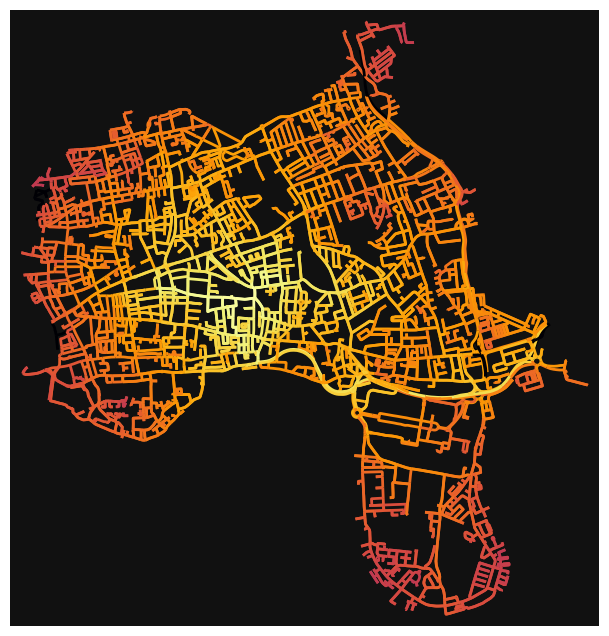

In [17]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

## Routing

In [18]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

In [ ]:
# get the nearest network nodes to two lat/lng points with the distance module
orig = ox.distance.nearest_nodes(G, X=-122.245846, Y=37.828903)
dest = ox.distance.nearest_nodes(G, X=-122.215006, Y=37.812303)

In [ ]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [ ]:
# how long is our route in meters?
edge_lengths = ox.utils_graph.route_to_gdf(G, route)["length"]
round(sum(edge_lengths))

In [ ]:
# how far is it between these two nodes as the crow flies?
# use OSMnx's vectorized great-circle distance (haversine) function
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
round(ox.distance.great_circle_vec(orig_y, orig_x, dest_y, dest_x))

You can add elevation attributes to your graph's nodes automatically with the `elevation` module, using either local raster files or the Google Maps Elevation API.

In [ ]:
# add elevation to nodes automatically, calculate edge grades, plot network
# you need a google elevation api key to run this cell!
try:
    from keys import google_elevation_api_key

    G = ox.elevation.add_node_elevations_google(G, api_key=google_elevation_api_key)
    G = ox.elevation.add_edge_grades(G)
    nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
    fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, edge_linewidth=2, edge_color="#333")
except ImportError:
    print("You need a google_elevation_api_key to run this cell.")

Nodes are colored from lowest elevation (dark blue) to highest (bright yellow).

Example: create [elevation-based](12-node-elevations-edge-grades.ipynb) impedance functions to route around hills.

## Get networks other ways

make queries less ambiguous to help the geocoder out, if it's not finding what you're looking for

In [ ]:
# you can make query an unambiguous dict to help the geocoder find it
place = {"city": "San Francisco", "state": "California", "country": "USA"}
G = ox.graph_from_place(place, network_type="drive", truncate_by_edge=True)
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color="y", edge_linewidth=0.2)

In [ ]:
# you can get networks anywhere in the world
G = ox.graph_from_place("Sinalunga, Italy", network_type="all")
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5)

In [ ]:
# or get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want
wurster_hall = (37.870605, -122.254830)
one_mile = 1609  # meters
G = ox.graph_from_point(wurster_hall, dist=one_mile, network_type="drive")
fig, ax = ox.plot_graph(G, node_size=0)

Examples of [getting networks](01-overview-osmnx.ipynb) by coordinates, bounding box, or any custom polygon shape.

## Get other networked infrastructure types

...like rail or electric grids or even the canals of Venice and Amsterdam, using the `custom_filter` parameter: [see more examples](08-custom-filters-infrastructure.ipynb).

In [ ]:
# get NY subway rail network
G = ox.graph_from_place(
    "New York, New York, USA",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["railway"~"subway"]',
)

fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

## Get any geospatial features' geometries and attributes

Use the `features` module to download any OSM features, such as local amenities, points of interest, or building footprints, and turn them into a GeoDataFrame: [see docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.features). For more usage examples of downloading geospatial features from OSM, see [this notebook](16-download-osm-geospatial-features.ipynb).

In [ ]:
# get all building footprints in some neighborhood
place = "SoHo, New York, NY"
tags = {"building": True}
gdf = ox.features_from_place(place, tags)
gdf.shape

In [ ]:
fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))

See the other notebooks for more examples of visualization with OSMnx.

In [ ]:
# get all parks and bus stops in some neighborhood
tags = {"leisure": "park", "highway": "bus_stop"}
gdf = ox.features_from_place(place, tags)
gdf.shape